### 1.包导入

In [1]:
import gym
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import pickle

### 2.环境尝试

In [2]:
env = gym.make('CartPole-v1')
env.reset()
env.step(0)


(array([-0.02523658, -0.19744457,  0.01249356,  0.2953384 ], dtype=float32),
 1.0,
 False,
 False,
 {})

### 3.定义策略网络

In [3]:
# 定义策略网络
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)   # 隐藏层
        self.fc3 = nn.Linear(128, output_dim)  # 输出动作概率
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = T.tensor(x, dtype=T.float32).to(self.device) 
        layer1 = T.relu(self.fc1(x))
        layer2 = T.relu(self.fc2(layer1))
        p = T.softmax(self.fc3(layer2), dim=-1)
        return p

### 4.计算折扣奖励函数

In [4]:
# 计算折扣奖励
def compute_returns(rewards, gamma):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns

### 5.设置环境和超参数

In [5]:
# 设置环境和超参数
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]  # 输入维度
output_dim = env.action_space.n             # 输出维度
policy_net = PolicyNetwork(input_dim, output_dim)
optimizer = optim.AdamW(policy_net.parameters(), lr=0.00001)
gamma = 0.9  # 折扣因子
avg_episode = 50
save_episode = 500
print_episode = 100

# 学习进度保存路径
model_path = "./save/s1_policy_net.pth"
avg_path = "./save/s1_avg_rewards.pth"

In [6]:
avg_rewards = []

continue_train = True
if continue_train:
    policy_net.load_state_dict(T.load(model_path))
    policy_net.to(policy_net.device)
    with open(avg_path, "rb") as f:
        avg_rewards = pickle.load(f)
len(avg_rewards)

/tmp/ipykernel_27990/3549617412.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(T.load(model_path))


120

### 6.开始训练

In [7]:
num_episodes = 5000
# 开始训练
record_rewards = []
for episode in range(1,num_episodes+1):
    # state = torch.tensor(env.reset()[0], dtype=torch.float32).to(policy_net.device)
    log_probs = []
    rewards = []
    state = env.reset()[0]
    # 采样轨迹
    done = False
    while not done:
        
        # state = torch.tensor(np.array(state), dtype=torch.float32)  # Ensure state tensor is on the correct device
        probs = policy_net(state)
        m = Categorical(probs) # 创建一个类别分布
        action = m.sample()  # 采样动作
        log_probs.append(m.log_prob(action))  # 记录 log(prob)
        # 执行动作
        state, reward, terminated, truncated, info = env.step(action.item())
        state = T.tensor(state, dtype=T.float32).to(policy_net.device)
        # print(f"state: {state}")
        done = bool(terminated) or bool(truncated)  # Ensure done is a boolean value
        rewards.append(reward)

    # 记录本次总得分 
    record_rewards.append(sum(rewards))

    # 计算累计回报
    returns = compute_returns(rewards, gamma)
    returns = T.tensor(returns, dtype=T.float32).to(policy_net.device)  # Ensure returns tensor is on the correct device
    
    # 标准化回报，以减少方差
    # returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    
    # 计算损失
    policy_loss = []
    for log_prob, G in zip(log_probs, returns):
        policy_loss.append(-log_prob * G)  # REINFORCE的损失：-log_prob * G
    policy_loss = T.stack(policy_loss).sum()
    
    # 反向传播和优化
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
    
    # 输出训练进度
    if episode % avg_episode == 0:
        avg_reward = sum(record_rewards[-avg_episode:])/avg_episode
        avg_rewards.append(avg_reward)
        if episode % print_episode == 0:
            print(f"Episode {episode}, Current Reward:{record_rewards[-1]}, Avg Reward: {avg_reward}")
        if episode % save_episode == 0:
            print(f"to save model and avg_rewards {len(avg_rewards)}")
            T.save(policy_net.state_dict(),model_path)
            with open(avg_path, "wb") as f:
                pickle.dump(avg_rewards, f)



/tmp/ipykernel_27990/3120889130.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = T.tensor(x, dtype=T.float32).to(self.device)


Episode 100, Current Reward:213.0, Avg Reward: 205.84
Episode 200, Current Reward:140.0, Avg Reward: 203.38
Episode 300, Current Reward:203.0, Avg Reward: 209.1
Episode 400, Current Reward:270.0, Avg Reward: 205.18
Episode 500, Current Reward:273.0, Avg Reward: 204.84
to save model and avg_rewards 130
Episode 600, Current Reward:177.0, Avg Reward: 217.2
Episode 700, Current Reward:218.0, Avg Reward: 203.52
Episode 800, Current Reward:124.0, Avg Reward: 195.4
Episode 900, Current Reward:145.0, Avg Reward: 201.12
Episode 1000, Current Reward:146.0, Avg Reward: 204.4
to save model and avg_rewards 140
Episode 1100, Current Reward:189.0, Avg Reward: 201.68
Episode 1200, Current Reward:210.0, Avg Reward: 183.12
Episode 1300, Current Reward:162.0, Avg Reward: 186.64
Episode 1400, Current Reward:213.0, Avg Reward: 175.98
Episode 1500, Current Reward:199.0, Avg Reward: 201.38
to save model and avg_rewards 150
Episode 1600, Current Reward:166.0, Avg Reward: 193.28
Episode 1700, Current Reward:29

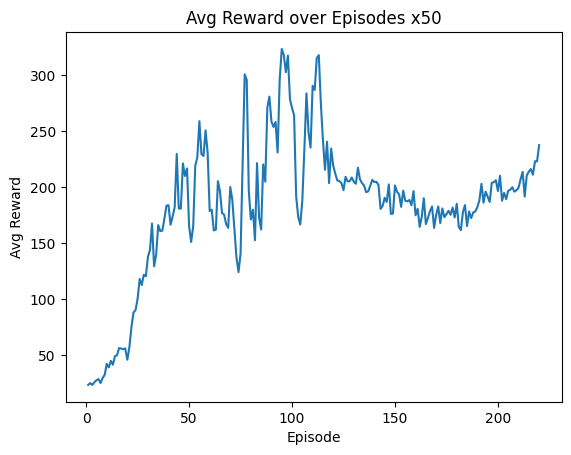

In [8]:
import matplotlib.pyplot as plt
# 绘制得分变化图
plt.plot(range(1, len(avg_rewards) + 1), avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg Reward')
plt.title(f'Avg Reward over Episodes x{avg_episode}')
plt.show()